## Train a Segmentation Model

This notebook trains a segmentation model on some Sentinel-2 data using crop labels from Radiant Earth's [South Africa Crop Type Competition](http://registry.mlhub.earth/10.34911/rdnt.j0co8q/).

In [1]:
import pystac
import pystac_client
import requests
import shapely.geometry
import datetime
import rioxarray
import pystac_client
import planetary_computer
import stackstac
import torch
import requests
import torch.utils.data
import functools
import rasterio.plot

import warnings
warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

I made a STAC catalog for the label data.

In [2]:
training_catalog = pystac.read_file(
    "https://esip2021.blob.core.windows.net/esip2021/train/collection.json"
)

Each Item is a single scene with one or more fields.

In [3]:
label_items = list(training_catalog.get_all_items())
label_item = label_items[0]
label_item

<Item id=ref_south_africa_crops_competition_v1_train_labels_2587>

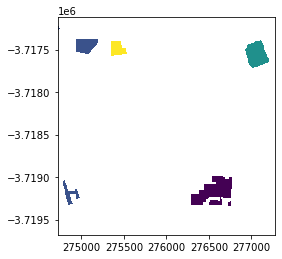

In [4]:
rasterio.plot.show(
    rasterio.open(label_item.assets["labels"].get_absolute_href())
);

They have links to the meaning of the class labels

In [5]:
labels = requests.get(label_items[0].assets['raster_values'].get_absolute_href()).json()
labels

{'0': 'No Data',
 '1': 'Lucerne/Medics',
 '2': 'Planted pastures (perennial)',
 '3': 'Fallow',
 '4': 'Wine grapes',
 '5': 'Weeds',
 '6': 'Small grain grazing',
 '7': 'Wheat',
 '8': 'Canola',
 '9': 'Rooibos'}

## Dataset / Dataloader

We'll write a helper to load

* the labels
* a corresponding scene from sentinel, cropped and transformed to the same area and CRS as the labels

In [6]:
@functools.lru_cache()
def get_item(label_item, assets):
    assets = list(assets)
    stac = pystac_client.Client.open(
        "https://planetarycomputer-staging.microsoft.com/api/stac/v1/"
    )
    labels = rioxarray.open_rasterio(
        label_item.assets['labels'].get_absolute_href()
    ).squeeze()

    month = datetime.timedelta(days=31)
    label_date = label_item.datetime
    date_range = f"{label_date - month:%Y-%m-%d}/{label_date + month:%Y-%m-%d}"

    search = stac.search(collections=["sentinel-2-l2a"], intersects=label_item.geometry, limit=500, datetime=date_range)
    items = list(search.get_all_items())
    # TODO: what if a label raster spans a sentinel scene?
    sentinel_item = sorted(
        items,
        key=lambda item: pystac.extensions.eo.EOExtension.ext(item).cloud_cover
    )[0]

    sentinel_item = sorted(
        items,
        key=lambda item: pystac.extensions.eo.EOExtension.ext(item).cloud_cover
    )[0]

    bounds = tuple(round(x, 0) for x in labels.rio.bounds())

    data = stackstac.stack(
        planetary_computer.sign(sentinel_item).to_dict(),
        assets=assets, dtype="float32", resolution=10,
        bounds=bounds, epsg=labels.rio.crs.to_epsg()
    ).squeeze()
    #where(lambda x: x > 0).squeeze()

    assert data.shape[1:] == labels.shape
    data = data.assign_coords(x=labels.x.data, y=labels.y.data)
    return data.compute(), labels

We'll wrap that up in a small pytorch Dataset class:

In [7]:
class STACDataset(torch.utils.data.Dataset):
    def __init__(self, label_items, labels, assets):
        self.label_items = label_items
        self.labels = labels
        self.assets = tuple(assets)

    def __len__(self):
        return len(self.label_items)

    def __getitem__(self, idx):
        label_item = self.label_items[idx]
        X, y = get_item(label_item, assets=self.assets)
        # TODO: Who should handle device stuff?
        X = torch.as_tensor(X.data).to("cuda:0")
        y = torch.as_tensor(y.data.astype("int64")).to("cuda:0")
        return X, y

In [8]:
dataset = STACDataset(label_items, labels, assets=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"])
loader = torch.utils.data.DataLoader(dataset)

## Model Definition

In [9]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(
    in_channels=len(dataset.assets), # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=len(labels),             # model output channels (number of classes in your dataset)
)

# loss = smp.losses.SoftCrossEntropyLoss(smooth_factor=0.1)
loss = smp.utils.losses.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model.parameters()))
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device="cuda:0",
    verbose=True,
)

## Training

In [10]:
%%time
with torch.cuda.device(0):
    for i in range(10):
        train_epoch.run(loader)

train: 100%|██████████| 20/20 [00:01<00:00, 13.94it/s, cross_entropy_loss - 1.051, iou_score - -1.828] 
CPU times: user 19.5 s, sys: 1.01 s, total: 20.5 s
Wall time: 1min 3s


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def visualize(X, y):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True)

    with torch.no_grad():
        X2 = (X.reshape((1,) + X.shape)).to("cuda")
        output = model.predict(X2)
    rasterio.plot.show(np.asarray(output[0].argmax(0).to("cpu")), ax=ax1);
    rasterio.plot.show(np.asarray(y.to("cpu")), ax=ax2)
    return ax1, ax2

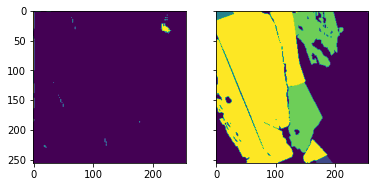

In [12]:
visualize(*dataset[8]);

Hmm doesn't seem great. We're just predicting 0 (no crops) a bunch. Bad data? More epochs? More data? Bad architechture? Who knows.

In [13]:
%%time
with torch.cuda.device(0):
    for i in range(10):
        train_epoch.run(loader)

train: 100%|██████████| 20/20 [00:01<00:00, 13.93it/s, cross_entropy_loss - 0.8673, iou_score - 1.767]  
CPU times: user 14.5 s, sys: 115 ms, total: 14.6 s
Wall time: 14.6 s


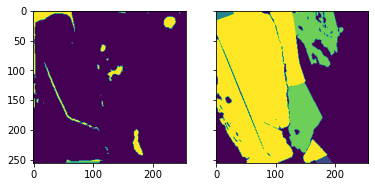

In [14]:
visualize(*dataset[8]);

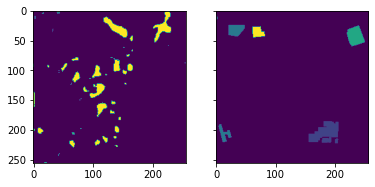

In [15]:
visualize(*dataset[0]);